In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from math import sin, cos, radians

img1 = cv.imread("front.png", cv.IMREAD_GRAYSCALE)
img2 = cv.imread("left.png", cv.IMREAD_GRAYSCALE)

sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i, (m, n) in enumerate(matches):
    if m.distance < 0.8 * n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

In [2]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_LMEDS)

# We select only inlier points
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

In [3]:
def drawlines(img1, img2, lines, pts1, pts2):
    """img1 - image on which we draw the epilines for the points in img2
    lines - corresponding epilines"""
    r, c = img1.shape
    img1 = cv.cvtColor(img1, cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2, cv.COLOR_GRAY2BGR)
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1]])
        img1 = cv.line(img1, (x0, y0), (x1, y1), color, 1)
        img1 = cv.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2

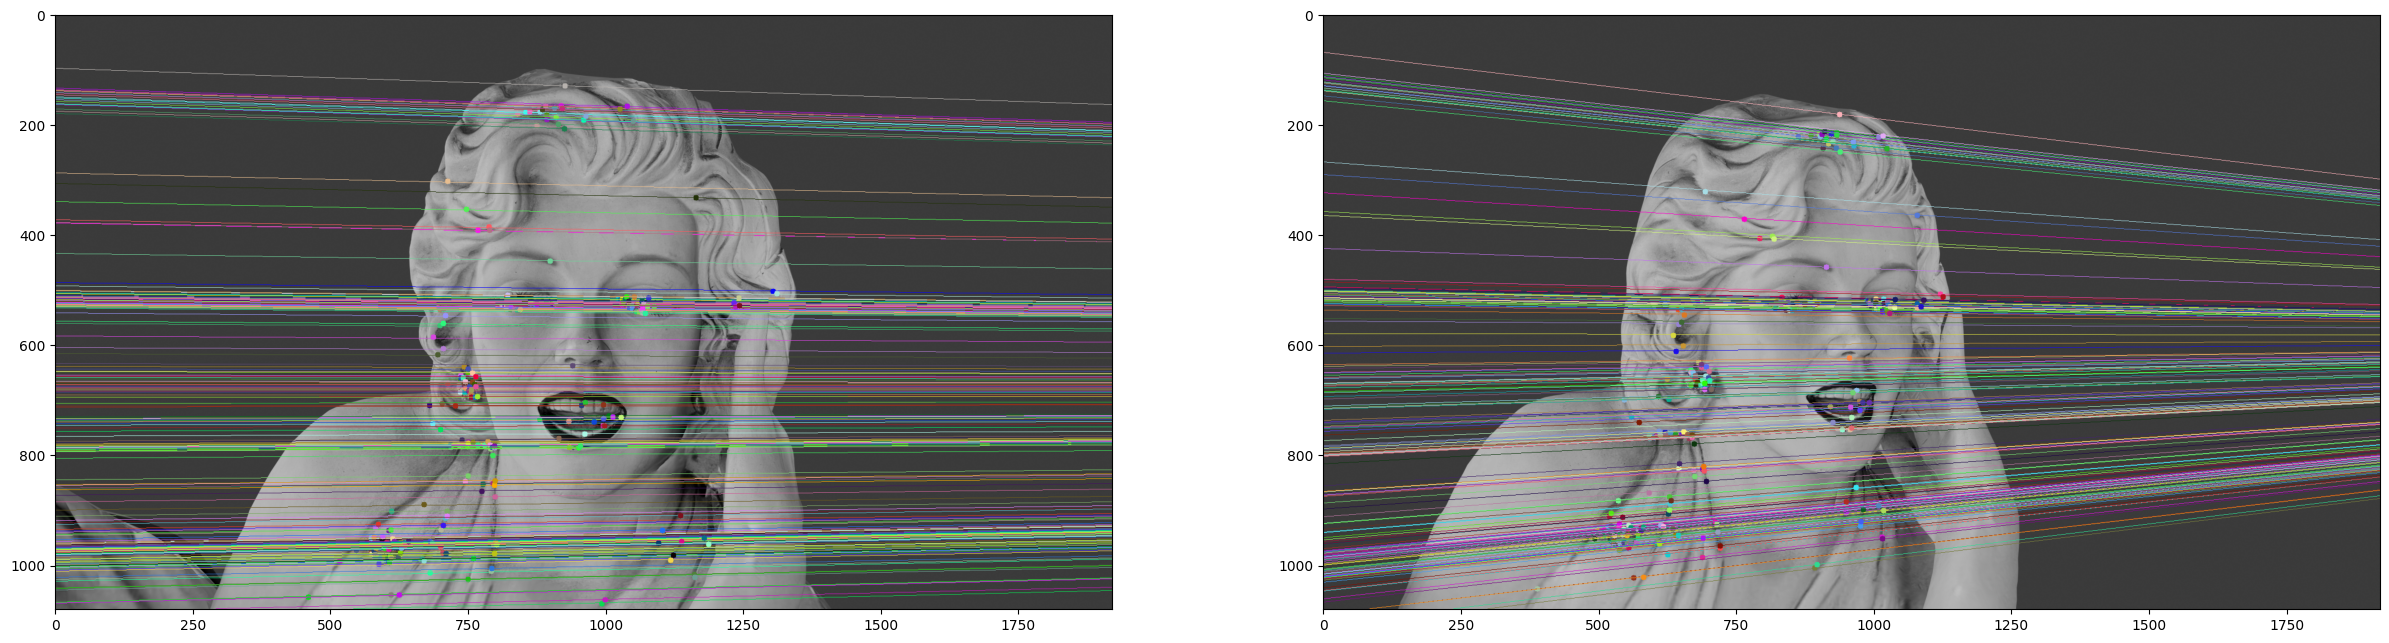

Number of point matches: 294


In [4]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)

plt.figure(figsize=(30, 18))
plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.show()


print(f"Number of point matches: {len(pts1)}")

In [5]:
# original

%matplotlib qt

# import numpy as np
# import cv2 as cv
# import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Camera intrinsics
focal_length_mm = 50
sensor_width_mm = 36
image_width_px = 1920
image_height_px = 1080

# Calculate focal length in pixels
focal_length_px = (focal_length_mm / sensor_width_mm) * image_width_px

# Camera intrinsics matrix
K = np.array(
    [
        [focal_length_px, 0, image_width_px / 2],
        [0, focal_length_px, image_height_px / 2],
        [0, 0, 1],
    ]
)

R1 = cv.Rodrigues(np.deg2rad([9, 0, 0]))[0]
t1 = np.array([[0], [0], [-1]])

R2 = cv.Rodrigues(np.deg2rad([-30, 0, 0]))[0]
t2 = np.array([[-0.5], [0], [-1]])

# Projection matrices
P1 = K @ np.hstack((R1, t1))  # Projection matrix for the first camera
P2 = K @ np.hstack((R2, t2))  # Projection matrix for the second camera

# Assuming pts1 and pts2 are your matched points
# Ensure pts1 and pts2 are numpy arrays
pts1 = np.array(pts1, dtype=np.float32)  # 2D points from image 1
pts2 = np.array(pts2, dtype=np.float32)  # 2D points from image 2

# Check for equal lengths
if pts1.shape[0] != pts2.shape[0]:
    raise ValueError("The number of points in pts1 and pts2 must be the same.")

# Convert to homogeneous coordinates
pts1_hom = cv.convertPointsToHomogeneous(pts1).reshape(-1, 3)  # shape (N, 3)
pts2_hom = cv.convertPointsToHomogeneous(pts2).reshape(-1, 3)  # shape (N, 3)

# Triangulation
points_4D = cv.triangulatePoints(
    P1, P2, pts1_hom[:, :2].T, pts2_hom[:, :2].T
)  # shape (4, N)

# Normalize to convert to 3D coordinates
points_3D = points_4D[:3] / points_4D[3]  # Normalize by the last row

plt.figure(figsize=(10, 7))
ax = plt.axes(projection="3d")

# Scatter plot of the 3D points
ax.scatter(points_3D[0], points_3D[1], points_3D[2], c="b", marker="o")

ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_zlabel("Z Coordinate")
ax.set_title("3D Points Reconstruction")

plt.show()

In [ ]:
# %matplotlib qt

# # import numpy as np
# # import cv2 as cv
# # import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# # Camera intrinsics
# import numpy as np
# import cv2 as cv

# # === Camera Intrinsics ===
# focal_length_mm = 50
# sensor_width_mm = 36
# image_width_px = 1920
# image_height_px = 1080

# focal_length_px = (focal_length_mm / sensor_width_mm) * image_width_px

# K = np.array([
#     [focal_length_px, 0, image_width_px / 2],
#     [0, focal_length_px, image_height_px / 2],
#     [0, 0, 1]
# ])

# # Helper to build rotation matrix from Euler angles in degrees (Blender XYZ)
# def euler_to_rotmat(x_deg, y_deg, z_deg):
#     x, y, z = np.deg2rad([x_deg, y_deg, z_deg])
#     Rx = np.array([
#         [1, 0, 0],
#         [0, np.cos(x), -np.sin(x)],
#         [0, np.sin(x),  np.cos(x)]
#     ])
#     Ry = np.array([
#         [np.cos(y), 0, np.sin(y)],
#         [0, 1, 0],
#         [-np.sin(y), 0, np.cos(y)]
#     ])
#     Rz = np.array([
#         [np.cos(z), -np.sin(z), 0],
#         [np.sin(z),  np.cos(z), 0],
#         [0, 0, 1]
#     ])
#     return Rz @ Ry @ Rx  # Blender uses XYZ order

# # === Camera 1 (world origin)
# C1_world = np.array([[0], [-1], [0]])  # Blender location
# R1_cam_world = euler_to_rotmat(90, 0, 0)  # Blender rotation
# R1 = R1_cam_world.T
# t1 = -R1 @ C1_world

# # === Camera 2
# C2_world = np.array([[-0.5], [-1], [0]])
# R2_cam_world = euler_to_rotmat(90, 0, -30)
# R2 = R2_cam_world.T
# t2 = -R2 @ C2_world

# # === Projection matrices
# P1 = K @ np.hstack((R1, t1))
# P2 = K @ np.hstack((R2, t2))

# # Assuming pts1 and pts2 are your matched points
# # Ensure pts1 and pts2 are numpy arrays
# pts1 = np.array(pts1, dtype=np.float32)  # 2D points from image 1
# pts2 = np.array(pts2, dtype=np.float32)  # 2D points from image 2

# # Check for equal lengths
# if pts1.shape[0] != pts2.shape[0]:
#     raise ValueError("The number of points in pts1 and pts2 must be the same.")

# # Convert to homogeneous coordinates
# pts1_hom = cv.convertPointsToHomogeneous(pts1).reshape(-1, 3)  # shape (N, 3)
# pts2_hom = cv.convertPointsToHomogeneous(pts2).reshape(-1, 3)  # shape (N, 3)

# # Triangulation
# points_4D = cv.triangulatePoints(
#     P1, P2, pts1_hom[:, :2].T, pts2_hom[:, :2].T
# )  # shape (4, N)

# # Normalize to convert to 3D coordinates
# points_3D = points_4D[:3] / points_4D[3]  # Normalize by the last row

# plt.figure(figsize=(10, 7))
# ax = plt.axes(projection="3d")

# # Scatter plot of the 3D points
# ax.scatter(points_3D[0], points_3D[1], points_3D[2], c="b", marker="o")

# ax.set_xlabel("X Coordinate")
# ax.set_ylabel("Y Coordinate")
# ax.set_zlabel("Z Coordinate")
# ax.set_title("3D Points Reconstruction")

# plt.show()

2025-04-16 14:20:46.144 python[40835:201299] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-16 14:20:46.144 python[40835:201299] +[IMKInputSession subclass]: chose IMKInputSession_Modern


In [7]:
# %matplotlib qt

# # import numpy as np
# # import cv2 as cv
# # import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# # Camera intrinsics
# focal_length_mm = 50
# sensor_width_mm = 36
# image_width_px = 1920
# image_height_px = 1080

# # Calculate focal length in pixels
# focal_length_px = (focal_length_mm / sensor_width_mm) * image_width_px

# # Camera intrinsics matrix
# K = np.array(
#     [
#         [focal_length_px, 0, image_width_px / 2],
#         [0, focal_length_px, image_height_px / 2],
#         [0, 0, 1],
#     ]
# )

# R2 = cv.Rodrigues(np.deg2rad([90, 0, 0]))[0]
# t2 = np.array([[0], [-1], [0]])

# R1 = cv.Rodrigues(np.deg2rad([90, 0, -30]))[0]
# t1 = np.array([[-0.5], [-1], [0]])

# # Projection matrices
# P1 = K @ np.hstack((R1, t1))  # Projection matrix for the first camera
# P2 = K @ np.hstack((R2, t2))  # Projection matrix for the second camera

# # Assuming pts1 and pts2 are your matched points
# # Ensure pts1 and pts2 are numpy arrays
# pts1 = np.array(pts1, dtype=np.float32)  # 2D points from image 1
# pts2 = np.array(pts2, dtype=np.float32)  # 2D points from image 2

# # Check for equal lengths
# if pts1.shape[0] != pts2.shape[0]:
#     raise ValueError("The number of points in pts1 and pts2 must be the same.")

# # Convert to homogeneous coordinates
# pts1_hom = cv.convertPointsToHomogeneous(pts1).reshape(-1, 3)  # shape (N, 3)
# pts2_hom = cv.convertPointsToHomogeneous(pts2).reshape(-1, 3)  # shape (N, 3)

# # Triangulation
# points_4D = cv.triangulatePoints(
#     P1, P2, pts1_hom[:, :2].T, pts2_hom[:, :2].T
# )  # shape (4, N)

# # Normalize to convert to 3D coordinates
# points_3D = points_4D[:3] / points_4D[3]  # Normalize by the last row

# plt.figure(figsize=(10, 7))
# ax = plt.axes(projection="3d")

# # Scatter plot of the 3D points
# ax.scatter(points_3D[0], points_3D[1], points_3D[2], c="b", marker="o")

# ax.set_xlabel("X Coordinate")
# ax.set_ylabel("Y Coordinate")
# ax.set_zlabel("Z Coordinate")
# ax.set_title("3D Points Reconstruction")

# plt.show()